In [2]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger
from models import ResearchModels
from data import DataSet
import time


Using TensorFlow backend.


In [3]:
model = 'lstm'  # see `models.py` for more
saved_model = None  # None or weights file
class_limit = None  # int, can be 1-101 or None
seq_length = 90
load_to_memory = True  # pre-load the sequences into memory

data_type = 'features'
image_shape = None
concat = False

batch_size = 32

In [4]:
%env CUDA_VISIBLE_DEVICES=1
data = DataSet(seq_length=seq_length,class_limit=class_limit)
#X, y = data.get_all_sequences_in_memory(batch_size, 'train', data_type, concat)
X_test, y_test = data.get_all_sequences_in_memory(batch_size, 'test', data_type, concat)
rm = ResearchModels(len(data.classes), model, seq_length, saved_model)

rm.model.load_weights("data/checkpoints/lstm-features.000-1.574.hdf5")
print("Created model and loaded weights from file")

env: CUDA_VISIBLE_DEVICES=1
Getting test data with 799 samples.


Loading LSTM model.


Created model and loaded weights from file


In [5]:
scores = rm.model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (rm.model.metrics_names[1], scores[1]*100))

acc: 45.31%


In [6]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = rm.model.predict_classes(X_test)
print(y_pred)

 32/799 [>.............................] - ETA: 3s

 64/799 [=>............................] - ETA: 2s

 96/799 [==>...........................] - ETA: 2s

128/799 [===>..........................] - ETA: 2s

160/799 [=====>........................] - ETA: 2s

192/799 [======>.......................] - ETA: 2s

224/799 [=======>......................] - ETA: 2s

256/799 [========>.....................] - ETA: 1s

288/799 [=========>....................] - ETA: 1s

320/799 [===========>..................] - ETA: 1s

352/799 [============>.................] - ETA: 1s

384/799 [=============>................] - ETA: 1s

416/799 [==============>...............] - ETA: 1s

448/799 [===============>..............] - ETA: 1s

480/799 [=================>............] - ETA: 1s

512/799 [==================>...........] - ETA: 1s

544/799 [===================>..........] - ETA: 0s

576/799 [====================>.........] - ETA: 0s

608/799 [=====================>........] - ETA: 0s

640/799 [=======================>......] - ETA: 0s

672/799 [========================>.....] - ETA: 0s

704/799 [=========================>....] - ETA: 0s

736/799 [==========================>...] - ETA: 0s

768/799 [===========================>..] - ETA: 0s

799/799 [==============================] - 2s     


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 3 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 0 0 1 1 0 1 1 0 1 1 1 1
 1 1 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3

In [25]:
print(np.argmax(y_test,axis=1))

[0 0 0 ..., 5 5 5]


In [23]:
y_true = ['1', '2', '3', '4', '5', '6']
print(confusion_matrix(np.argmax(y_test,axis=1), y_pred))

[[199   0   0   0   0   0]
 [  0 158  41   0   1   0]
 [  0  45 153   0   0   0]
 [  0   0   0 194   1   3]
 [  0   0   0   2 197   0]
 [  0   0   0   1   0 197]]


Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[199   0   0   0]
 [ 36 163   0   1]
 [  1   0  20 179]
 [  0 172   0  28]]
Normalized confusion matrix
[[ 1.    0.    0.    0.  ]
 [ 0.18  0.81  0.    0.01]
 [ 0.01  0.    0.1   0.9 ]
 [ 0.    0.86  0.    0.14]]


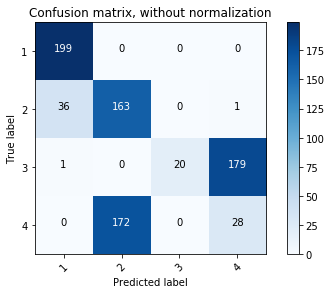

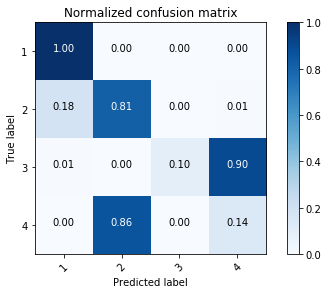

In [16]:
# %matplotlib inline
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

# from sklearn import svm, datasets
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix

# import some data to play with
# iris = datasets.load_iris()
# X = iris.data
# y = iris.target
# class_names = iris.target_names
# class_names = ['1', '2', '3', '4', '5', '6']
class_names = ['1', '2', '3', '4']
# 
# # Split the data into a training set and a test set
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
# 
# # Run classifier, using a model that is too regularized (C too low) to see
# # the impact on the results
# classifier = svm.SVC(kernel='linear', C=0.01)
# y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(np.argmax(y_test,axis=1), y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
fig1 = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
fig2 = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [17]:
fig2.savefig('./confusion_matrix2.png') # Use fig. here
# fig.savefig(saveas, dpi=1000, bbox_inches='tight') # Better quality and no cropped title

In [10]:
print(np.argmax(y_test,axis=1))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

In [15]:
y_pred=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,3,0,1,0,1,1,0,1,1,1,1,1,1,1,1,0,1,1
,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,0,1,0,0,1,1,0,1,1,0,1,1,1,1
,1,1,1,1,1,0,1,1,0,1,0,1,1,1,0,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,0,0,1,1,0
,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1
,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,0,1,0,1,1,1,1,1,1,1,0,1,1
,0,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,2,2,2,2,2,2
,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
,3,3,3,3,3,3,3,3,3,3,0,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,1,1
,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]